In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import scipy.signal
from scipy import *
import copy
import scienceplots

plt.style.use(['science','no-latex','bright'])

plt.rcParams['figure.figsize'] = [10, 4]
plt.rcParams['figure.dpi'] = 100

%matplotlib widget
# requires plt.figure() for each plot


---
# Mean-smooth a time series
---
In here basically we take the surrounding points around our target and calculate the mean. The key parameter is the number of adjacent points, known as the filter order (k). This kind of filters have the "edge effect" problem, that is, they don't use the edge points, and the most common option is either remove them or just keep their value, but this should be evaluated dependeing on the case.

![](img/running.png)


This filter is useful for gaussian noise, i.e., when the signal oscillates with positive and negative around some baseline.

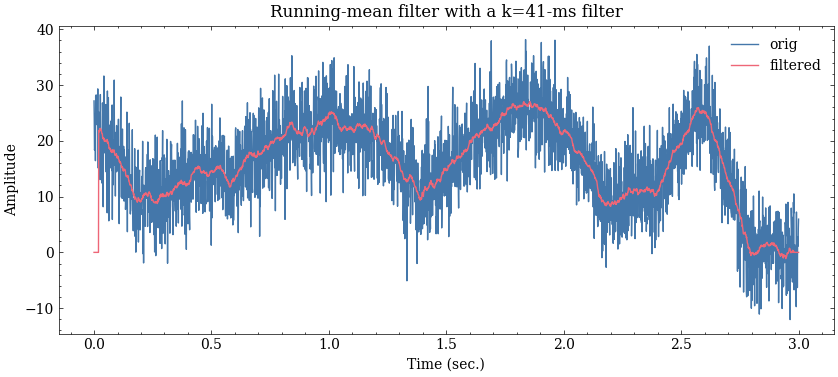

In [2]:
# create signal
srate = 1000 # Hz
time  = np.arange(0,3,1/srate)
n     = len(time)
p     = 15 # poles for random interpolation

# noise level, measured in standard deviations
noiseamp = 5

# amplitude modulator and noise level
ampl   = np.interp(np.linspace(0,p,n),np.arange(0,p),np.random.rand(p)*30)
noise  = noiseamp * np.random.randn(n)
signal = ampl + noise

# initialize filtered signal vector
filtsig = np.zeros(n) # setting zero for initialization but also for edge points

# implement the running mean filter
k = 20 # filter window is actually k*2+1, by increasing here the signal is more smoothed
for i in range(k,n-k): # ignoring edges
    # each point is the average of k surrounding points
    filtsig[i] = np.mean(signal[i-k:i+k])

# compute each window size of the running filter in ms
windowsize = ((k*2+1) / srate) * 1e3


# plot the noisy and filtered signals
# plt.figure(figsize=(10, 3), dpi=100)
plt.figure()
plt.plot(time,signal,label='orig')
plt.plot(time,filtsig,label='filtered')

plt.legend()
plt.xlabel('Time (sec.)')
plt.ylabel('Amplitude')
plt.title('Running-mean filter with a k=%d-ms filter' %windowsize)

plt.show()



---
# Gaussian-smooth a time series
---
Now we can apply the same principle but smoothing (weighting) the adjacent values with a Gaussian function. The Gaussian function normalizes all the components since the cumulative distribution function tends to 1.

![](img/gauss.png)

We will use the following formulation that allows to define the FWHM.

![](img/gauss2.png)

Usually a smoother result is obtained.

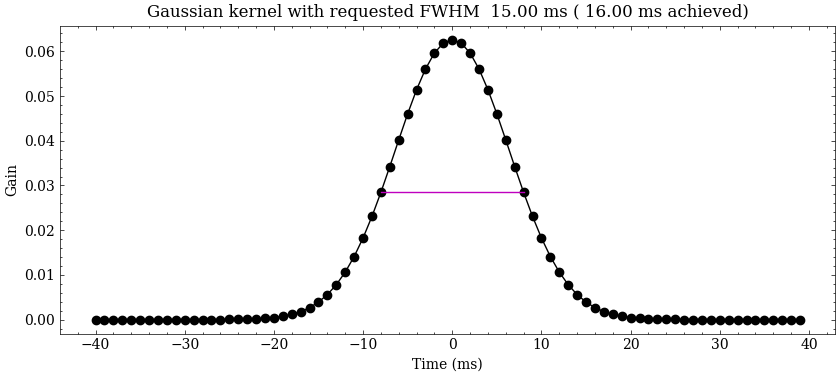

In [3]:
# create signal
srate = 1000 # Hz
time  = np.arange(0,3,1/srate)
n     = len(time)
p     = 15 # poles for random interpolation

# noise level, measured in standard deviations
noiseamp = 5

# amplitude modulator and noise level
ampl   = np.interp(np.linspace(1,p,n),np.arange(0,p),np.random.rand(p)*30)
noise  = noiseamp * np.random.randn(n)
signal = ampl + noise # similar signal as before

## create Gaussian kernel
# full-width half-maximum: the key Gaussian parameter
fwhm = 15 
"""
In ms, this is the theoretical of the Gaussian function, however its applied value will change according to srate mainly
Increasing it makes the result smoother but also requires to increase k, and thus the edge effect is amplified
"""

# normalized time vector in ms
k = 40
"""
This value should be big enough to ensure that function reaches nearly 0, so that FWHM is correctly captured
At the same time it should be not too big so we will have problems in the edges, because actually k is the number of points we "ignore"
"""

gtime = 1000*np.arange(-k,k)/srate

# create Gaussian window
gauswin = np.exp( -(4*np.log(2)*gtime**2) / fwhm**2 )

# compute empirical FWHM
pstPeakHalf = k + np.argmin( (gauswin[k:]-.5)**2 )
prePeakHalf = np.argmin( (gauswin-.5)**2 )

empFWHM = gtime[pstPeakHalf] - gtime[prePeakHalf]

# then normalize Gaussian to unit energy
gauswin = gauswin / np.sum(gauswin) # this ensures that the scale is maintaned in the original data

# show the Gaussian
plt.figure()
plt.plot(gtime,gauswin,'ko-')
plt.plot([gtime[prePeakHalf],gtime[pstPeakHalf]],[gauswin[prePeakHalf],gauswin[pstPeakHalf]],'m')

plt.title(f'Gaussian kernel with requested FWHM {fwhm : .2f} ms ({empFWHM : .2f} ms achieved)')
plt.xlabel('Time (ms)')
plt.ylabel('Gain')

plt.show()

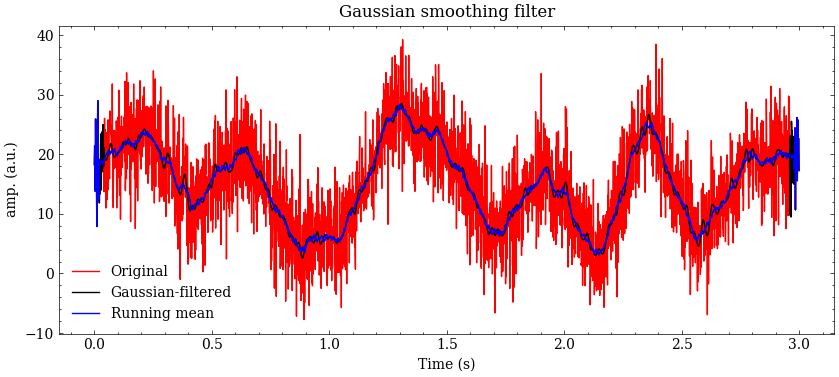

In [4]:
## implement the filter

# initialize filtered signal vector
filtsigG = copy.deepcopy(signal)

# # implement the running mean filter
for i in range(k+1,n-k):
    # each point is the weighted average of k surrounding points
    filtsigG[i] = np.sum( signal[i-k:i+k]*gauswin )

# plot
plt.figure()
plt.plot(time,signal,'r',label='Original')
plt.plot(time,filtsigG,'k',label='Gaussian-filtered')

plt.xlabel('Time (s)')
plt.ylabel('amp. (a.u.)')
plt.legend()
plt.title('Gaussian smoothing filter')

## for comparison, plot mean smoothing filter

# initialize filtered signal vector
filtsigMean = copy.deepcopy(signal)

# implement the running mean filter
# note: using mk instead of k to avoid confusion with k above
mk = 20 # filter window is actually mk*2+1
for i in range(mk+1,n-mk-1):
    # each point is the average of k surrounding points
    filtsigMean[i] = np.mean(signal[i-mk:i+mk])

plt.plot(time,filtsigMean,'b',label='Running mean')
plt.legend()
plt.show()


---
# Gaussian-smooth a spike time series
---


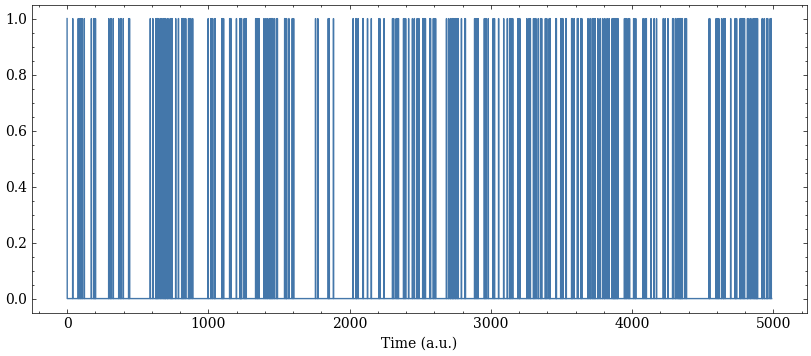

In [5]:
## generate time series of random spikes

# number of spikes
n = 300

# inter-spike intervals (exponential distribution for bursts)
isi = np.round(np.exp( np.random.randn(n) )*10)

# generate spike time series
spikets = np.zeros(int(sum(isi)))

for i in range(0,n):
    spikets[ int(np.sum(isi[0:i])) ] = 1

# plot
plt.figure()
plt.plot(spikets)
plt.xlabel('Time (a.u.)')
plt.show()

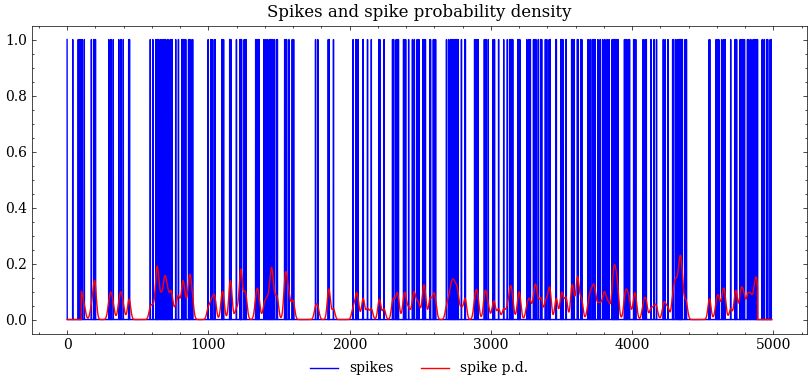

In [6]:
## create and implement Gaussian window

# full-width half-maximum: the key Gaussian parameter
fwhm = 25 # in points
"""
Big parameter flattens all the spikes and the positional information is lost
Little parameter just smooths every spike with no additional information
"""

# normalized time vector in points
k = 100;
gtime = np.arange(-k,k)

# create Gaussian window
gauswin = np.exp( -(4*np.log(2)*gtime**2) / fwhm**2 )
gauswin = gauswin / np.sum(gauswin)

# initialize filtered signal vector
filtsigG = np.zeros(len(spikets))

# implement the gaussian weighted running mean filter
for i in range(k+1,len(spikets)-k):
    filtsigG[i] = np.sum( spikets[i-k:i+k]*gauswin )


# plot the filtered signal (spike probability density)
plt.figure()
plt.plot(spikets,'b',label='spikes')
plt.plot(filtsigG,'r',label='spike p.d.')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=2)
plt.title('Spikes and spike probability density')
plt.show()


---
# Denoising via TKEO
---

For denoising signals like EMG (electromyogram) that presents small oscillations and sudden peaks of energy.

![](img/tkeo.png)


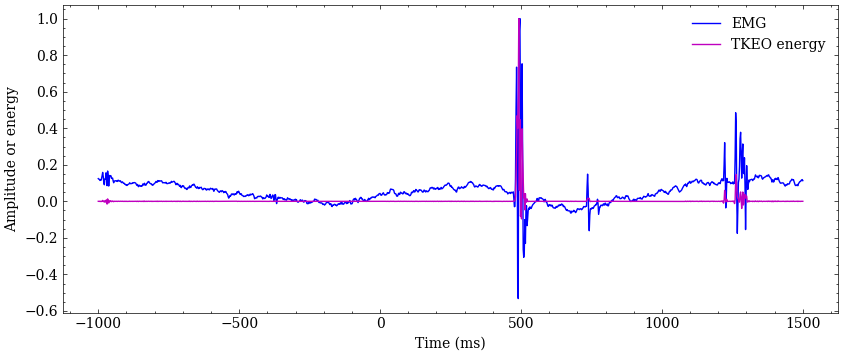

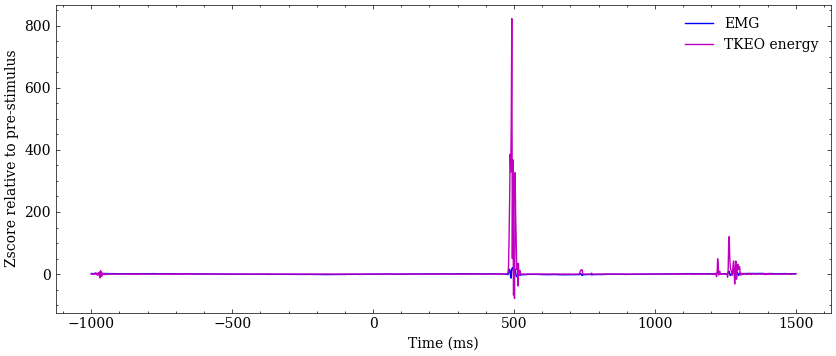

'\nThis second plot somehow describes the SNR or how many std we have from the baseline noise\n'

In [7]:
# import data
emgdata = sio.loadmat('data/emg4TKEO.mat')

# extract needed variables
emgtime = emgdata['emgtime'][0]
emg  = emgdata['emg'][0]

# initialize filtered signal
emgf = copy.deepcopy(emg)

# the loop version for interpretability
for i in range(1,len(emgf)-1): # we loose the edge points
    emgf[i] = emg[i]**2 - emg[i-1]*emg[i+1]

# the vectorized version for speed and elegance
emgf2 = copy.deepcopy(emg)
emgf2[1:-1] = emg[1:-1]**2 - emg[0:-2]*emg[2:]

"""
Now it's necessary to convert both signals to zscore since they were squared
"""

# find timepoint zero
time0 = np.argmin(emgtime**2) # squaring to make all values positive then find 0

# convert original EMG to z-score from time-zero
emgZ = (emg-np.mean(emg[0:time0])) / np.std(emg[0:time0]) # (signal - mean)/std

# same for filtered EMG energy
emgZf = (emgf-np.mean(emgf[0:time0])) / np.std(emgf[0:time0])
# this is done only for signal previous to 0 time


## plot
# plot "raw" (normalized to max.1) to compare on same scale
plt.figure()
plt.plot(emgtime,emg/np.max(emg),'b',label='EMG')
plt.plot(emgtime,emgf/np.max(emgf),'m',label='TKEO energy')
plt.xlabel('Time (ms)')
plt.ylabel('Amplitude or energy')
plt.legend()

plt.show()

# plot zscored
plt.figure()
plt.plot(emgtime,emgZ,'b',label='EMG')
plt.plot(emgtime,emgZf,'m',label='TKEO energy')

plt.xlabel('Time (ms)')
plt.ylabel('Zscore relative to pre-stimulus')
plt.legend()
plt.show()
"""
This second plot somehow describes the SNR or how many std we have from the baseline noise
"""


---
# Median filter to remove spike noise
---
This a nonlinear filter and as such it is recommended to apply only to a set of points, e.g., where we suspect there are outliers, and not the whole set of points. For spike type of noise, a mean filter will not work as it will consider the huge value of the spike and integrate it in the results, while the median ignores these values.

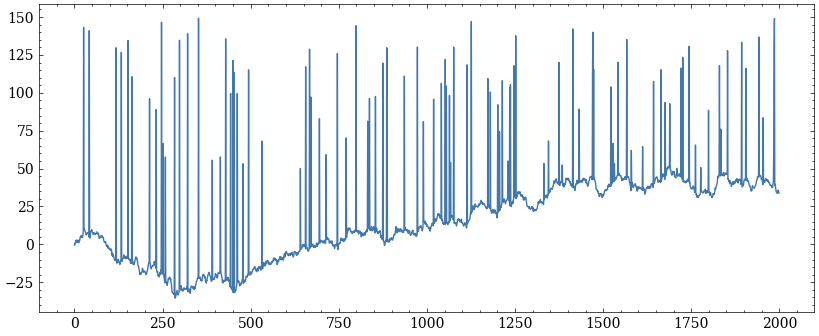

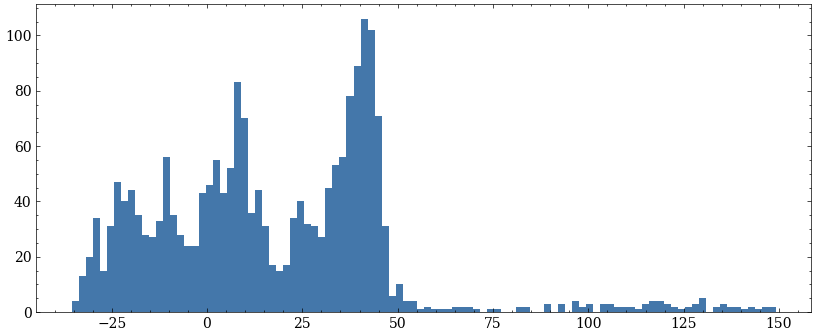

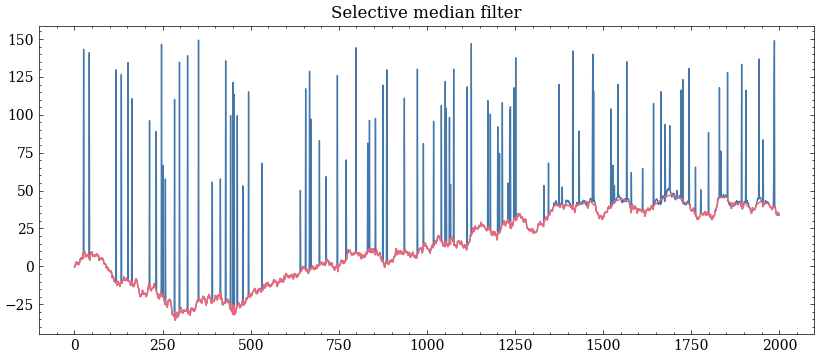

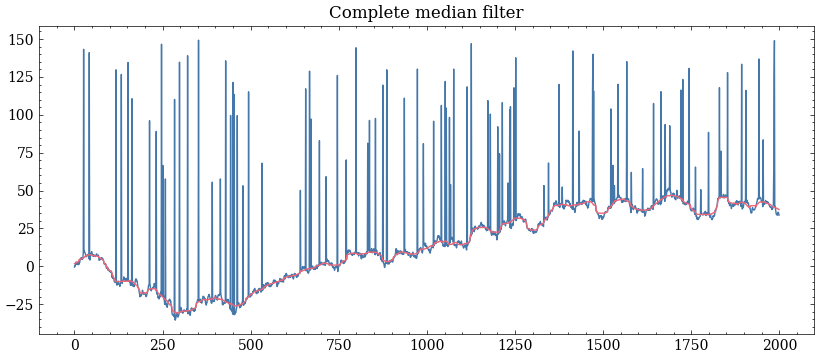

In [8]:
# create signal
n = 2000
signal = np.cumsum(np.random.randn(n)) # sort of brown noise

# proportion of time points to replace with noise
propnoise = .05
# this percentage of random points will simulate spike noise

# find noise points
noisepnts = np.random.permutation(n)
noisepnts = noisepnts[0:int(n*propnoise)]

# generate signal and replace points with noise
signal[noisepnts] = 50+np.random.rand(len(noisepnts))*100

plt.figure()
plt.plot(signal)
plt.show()
"""
From this plot we observe it will be difficult to set a precise threshold to do the nonlinear median filter
With the following histogram we assume that spike values are scarce and therefore we select the threshold
"""

# use hist to pick threshold
plt.figure()
plt.hist(signal,100)
plt.show()

# visual-picked threshold
threshold = 40

# find data values above the threshold
suprathresh = np.where( signal>threshold )[0]

# initialize filtered signal
filtsig = copy.deepcopy(signal)

# loop through suprathreshold points and set to median of k
k = 20 # actual window is k*2+1
for ti in range(len(suprathresh)):
    # lower and upper bounds
    lowbnd = np.max((0,suprathresh[ti]-k)) # to prevent picking values with index lower than 0
    uppbnd = np.min((suprathresh[ti]+k,n+1)) # to prevent picking values with index higher than max
    
    # compute median of surrounding points
    filtsig[suprathresh[ti]] = np.median(signal[lowbnd:uppbnd])
    
filtsigcomplete = copy.deepcopy(signal)
suprathresh = range(0,n)

# loop through suprathreshold points and set to median of k
k = 20 # actual window is k*2+1
for ti in range(len(suprathresh)):
    # lower and upper bounds
    lowbnd = np.max((0,suprathresh[ti]-k)) # to prevent picking values with index lower than 0
    uppbnd = np.min((suprathresh[ti]+k,n+1)) # to prevent picking values with index higher than max
    
    # compute median of surrounding points
    filtsigcomplete[suprathresh[ti]] = np.median(signal[lowbnd:uppbnd])

# plot
plt.figure()
plt.plot(range(0,n),signal, range(0,n),filtsig)
plt.title('Selective median filter')
plt.show()

plt.figure()
plt.plot(range(0,n),signal, range(0,n),filtsigcomplete)
plt.title('Complete median filter')
plt.show()



---
# Remove linear trend
---
When we capture a signal who has, for example, a growing global linear behavior but we are not interested in this, we want the local fluctuations, either due to the way we capture it (the device) or because what's relevant it's the actual values, what we can do is fit a straight line and substract it.

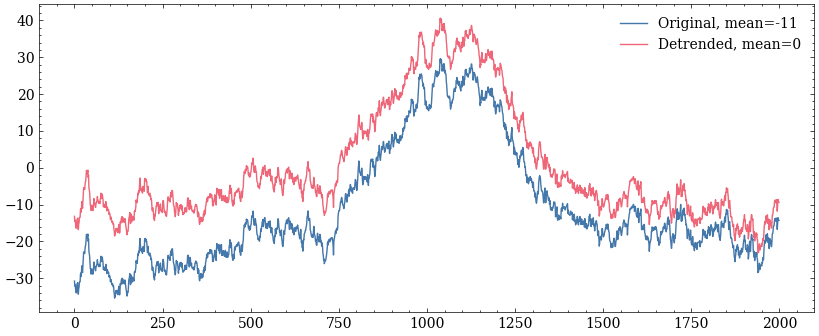

In [9]:
# create signal with linear trend imposed
n = 2000
signal = np.cumsum(np.random.randn(n)) + np.linspace(-30,30,n)

# linear detrending
detsignal = scipy.signal.detrend(signal)

# get means
omean = np.mean(signal) # original mean
dmean = np.mean(detsignal) # detrended mean

# plot signal and detrended signal
plt.figure()
plt.plot(range(0,n),signal,label='Original, mean=%d' %omean)
plt.plot(range(0,n),detsignal,label='Detrended, mean=%d' %dmean)

plt.legend()
plt.show()


---
# Remove nonlinear trend with polynomials
---
When we observe a straight line as before it's quite easy to remove the trend. But when the system has some drift while measuring or some physical fluctuations (like temperature) that cause changes in the receiver readings, we will observe a kind of DC offset.

In general we will need a high order polynomial to fit (and substract) the global trend. To find the order we can use Bayes information criterion.

![](img/bayesinfo.png)

What we see in the image is that first we calculate the Mean Squared error, adn then a lower value results in a lower b which is the target. The number of parameters k is also penalized, as a more complex model will fit better but not in a more optimized way.

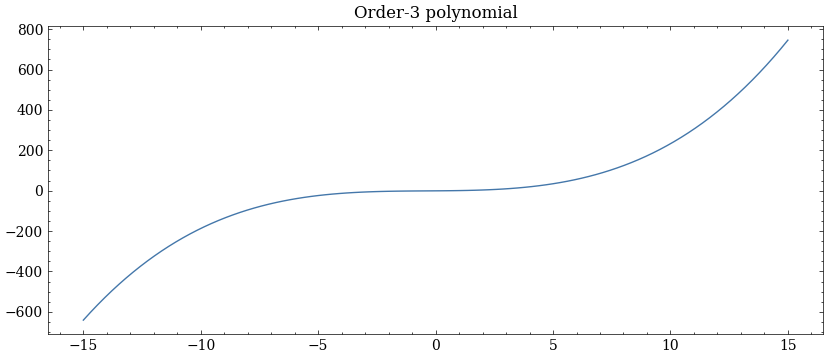

In [10]:
## polynomial intuition

order = 3
x = np.linspace(-15,15,100)

y = np.zeros(len(x))

for i in range(order+1):
    y = y + np.random.randn(1)*x**i

plt.figure()
plt.plot(x,y)
plt.title('Order-%d polynomial' %order)
plt.show()


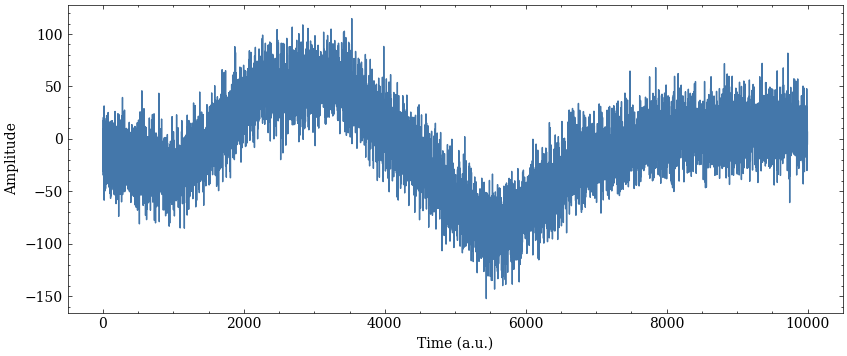

In [11]:
## generate signal with slow polynomial artifact

n = 10000
t = range(n)
k = 10 # number of poles for random amplitudes

slowdrift = np.interp(np.linspace(1,k,n),np.arange(0,k),100*np.random.randn(k))
signal = slowdrift + 20*np.random.randn(n)

# plot
plt.figure()
plt.plot(t,signal)
plt.xlabel('Time (a.u.)')
plt.ylabel('Amplitude')
plt.show()

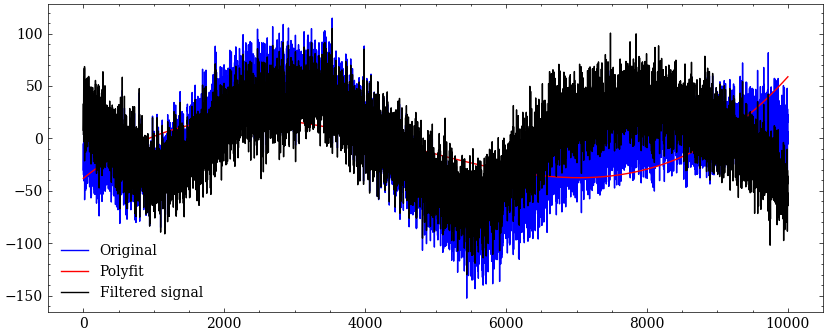

In [12]:
## fit a 3-order polynomial

# polynomial fit (returns coefficients)
p = np.polyfit(t,signal,3)

# predicted data is evaluation of polynomial
yHat = np.polyval(p,t)

# compute residual (the cleaned signal)
residual = signal - yHat

"""
As observed in the plot we will need a higher order to adjust the global trend of the data.
To find the optimal value we will use Bayes information
"""

# now plot the fit (the function that will be removed)
plt.figure()
plt.plot(t,signal,'b',label='Original')
plt.plot(t,yHat,'r',label='Polyfit')
plt.plot(t,residual,'k',label='Filtered signal')

plt.legend()
plt.show()

c:\Users\sebs9\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3457: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
c:\Users\sebs9\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3457: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
c:\Users\sebs9\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3457: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
c:\Users\sebs9\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3457: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
c:\Users\sebs9\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3457: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
c:\Users\sebs9\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3457: RankWarning: 

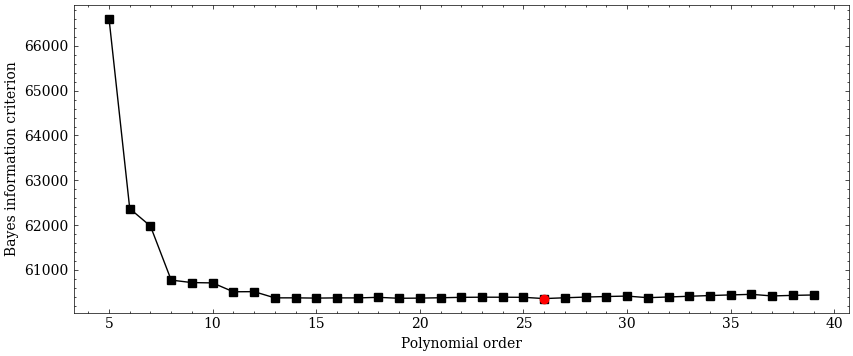

'\nThe warnings are just indications of poorly fitted polynomials.\nThe lowest value is clearer after zooming in. \nIn case where several orders will have roughly the same value, you can just any of them.\n'

In [13]:
## Bayes information criterion to find optimal order

# possible orders
orders = range(5,40) # k in formula

# sum of squared errors (sse is reserved!)
sse1 = np.zeros(len(orders))

# loop through orders
for ri in range(len(orders)):
    
    # compute polynomial (fitting time series)
    yHat = np.polyval(np.polyfit(t,signal,orders[ri]),t)
    
    # compute fit of model to data (sum of squared errors)
    sse1[ri] = np.sum( (yHat-signal)**2 )/n


# Bayes information criterion
bic = n*np.log(sse1) + orders*np.log(n)

# best parameter has lowest BIC
bestP = min(bic)
idx = np.argmin(bic)

# plot the BIC
plt.figure()
plt.plot(orders,bic,'ks-')
plt.plot(orders[idx],bestP,'ro')
plt.xlabel('Polynomial order')
plt.ylabel('Bayes information criterion')
plt.show()

"""
The warnings are just indications of poorly fitted polynomials.
The lowest value is clearer after zooming in. 
In case where several orders will have roughly the same value, you can just any of them.
"""

c:\Users\sebs9\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3457: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


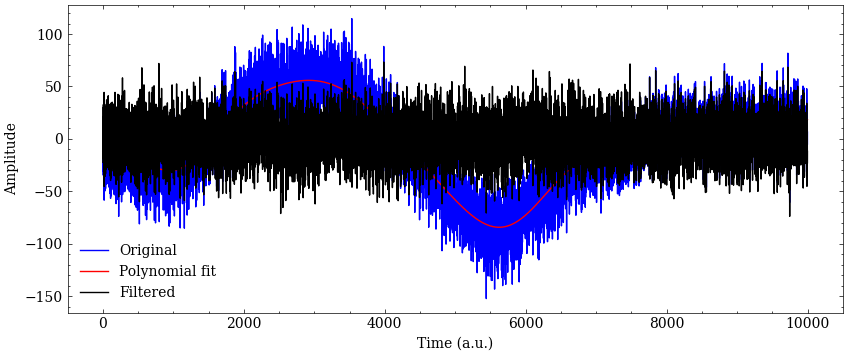

In [14]:
## now repeat filter for best (smallest) BIC

# polynomial fit
polycoefs = np.polyfit(t,signal,orders[idx])

# estimated data based on the coefficients
yHat = np.polyval(polycoefs,t)

# filtered signal is residual
filtsig = signal - yHat


## plotting
plt.figure()
plt.plot(t,signal,'b',label='Original')
plt.plot(t,yHat,'r',label='Polynomial fit')
plt.plot(t,filtsig,'k',label='Filtered')

plt.xlabel('Time (a.u.)')
plt.ylabel('Amplitude')
plt.legend()
plt.show()


---
# Averaging multiple repetitions (time-synchronous averaging)
---
Mainly to remove noise and find the real trend that is behind it.
It is key to align all the events (signals)  with some particular time so that they represent the same information.

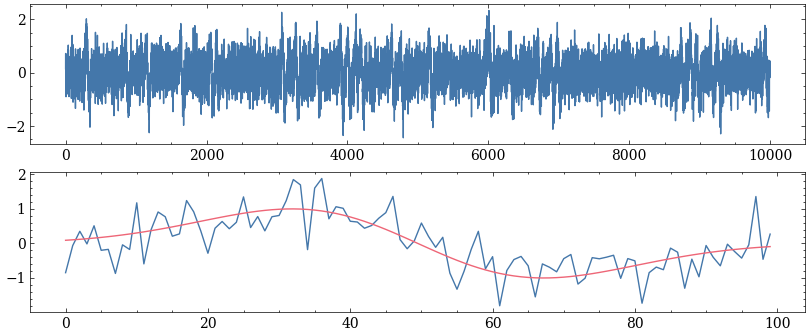

In [15]:
## simulate data

# create event (derivative of Gaussian)
k = 100 # duration of event in time points
event = np.diff(np.exp( -np.linspace(-2,2,k+1)**2 ))
event = event/np.max(event) # normalize to max=1

# event onset times: insert randomly the events
Nevents = 30
onsettimes = np.random.permutation(10000-k)
onsettimes = onsettimes[0:Nevents]

# put event into data: insert the events into random data
data = np.zeros(10000)
for ei in range(Nevents):
    data[onsettimes[ei]:onsettimes[ei]+k] = event

# add noise
data = data + .5*np.random.randn(len(data))

# plot data
plt.figure()
plt.subplot(211)
plt.plot(data)

# plot one event
plt.subplot(212)
plt.plot(range(k), data[onsettimes[3]:onsettimes[3]+k]) # measured event
plt.plot(range(k), event) # theoretical event
plt.show()

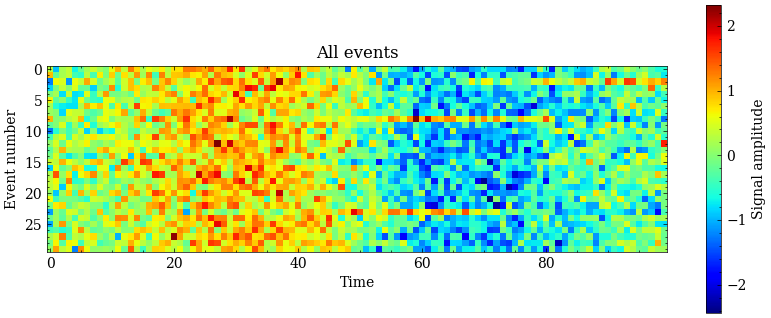

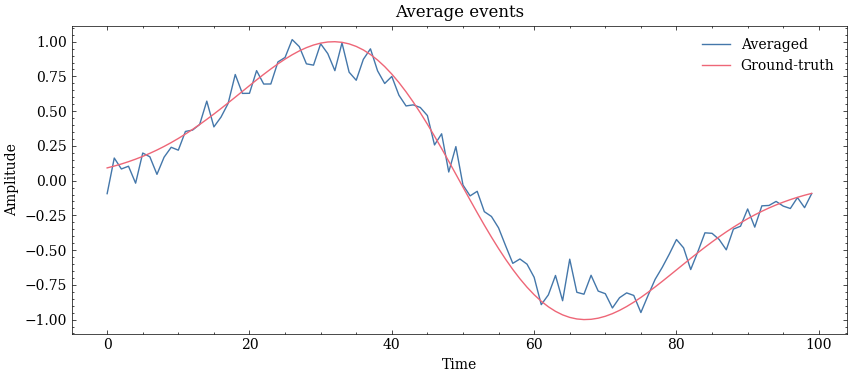

In [16]:
## extract all "experimental" events into a matrix

datamatrix = np.zeros((Nevents,k))

for ei in range(Nevents):
    datamatrix[ei,:] = data[onsettimes[ei]:onsettimes[ei]+k]

plt.figure()
plt.imshow(datamatrix,cmap='jet')
plt.xlabel('Time')
plt.ylabel('Event number')
plt.title('All events')
plt.colorbar(label='Signal amplitude')
plt.show()

plt.figure()
plt.plot(range(0,k),np.mean(datamatrix,axis=0),label='Averaged')
plt.plot(range(0,k),event,label='Ground-truth')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.legend()
plt.title('Average events')
plt.show()


---
# Remove artifact via least-squares template-matching
---
The goal is to find some pattern in the data that looks like an artifact. We are goin to take a statistical mapping between artifact data and target data. Features that best match the artifact in the target data will be removed.

![](img/lstm.png)


We start by doing a least-squares fitting using the image formula. It describes a regression of the artifact onto the target and then taking the residual. The design matrix will have the artifacts that we are looking to eliminate.

$X=\begin{bmatrix}
1 & a_1 \\
1 & a_2 \\
... & ... \\
1 & a_n
\end{bmatrix}$

In [17]:
# load dataset
matdat = sio.loadmat('data/templateProjection.mat')
EEGdat = matdat['EEGdat'] # some EEG data that is corrupted by eye motion during brain scan
eyedat = matdat['eyedat'] # the artifact data
timevec = matdat['timevec'][0]
MN = np.shape(EEGdat) # matrix sizes

# initialize residual data
resdat = np.zeros(np.shape(EEGdat))

# loop over trials
for triali in range(MN[1]):
    
    # build the least-squares model as intercept and EOG from this trial
    X = np.column_stack((np.ones(MN[0]),eyedat[:,triali])) # design matrix
    
    # compute regression coefficients for EEG channel
    b = np.linalg.solve(np.matrix.transpose(X)@X,np.matrix.transpose(X)@EEGdat[:,triali])
    
    # predicted data
    yHat = X@b
    
    # new data are the residuals after projecting out the best EKG fit
    resdat[:,triali] = EEGdat[:,triali] - yHat

C:\Users\sebs9\AppData\Local\Temp\ipykernel_20980\428957120.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


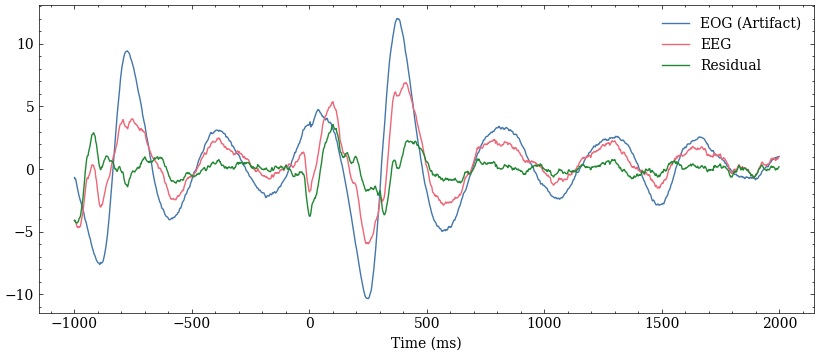

In [18]:
### plotting

# trial averages
plt.figure()
plt.plot(timevec,np.mean(eyedat,axis=1),label='EOG (Artifact)')
plt.plot(timevec,np.mean(EEGdat,axis=1),label='EEG')
plt.plot(timevec,np.mean(resdat,1),label='Residual')

plt.xlabel('Time (ms)')
plt.legend()
plt.show()

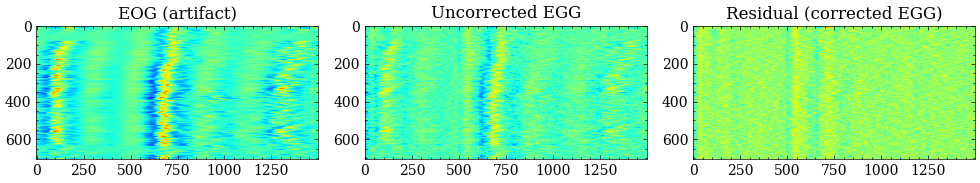

In [19]:
# show all trials in a map
clim = [-1,1]*20

plt.figure()
plt.subplot(131)
plt.imshow(eyedat.T,cmap='jet')
plt.title('EOG (artifact)')


plt.subplot(132)
plt.imshow(EEGdat.T,cmap='jet')
plt.title('Uncorrected EGG')


plt.subplot(133)
plt.imshow(resdat.T,cmap='jet')
plt.title('Residual (corrected EGG)')

plt.tight_layout()
plt.show()

# CHALLENGE: Apply denoising to find a similar signal

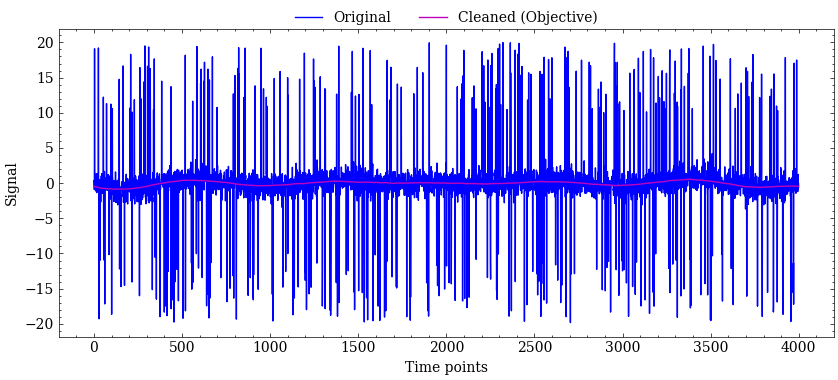

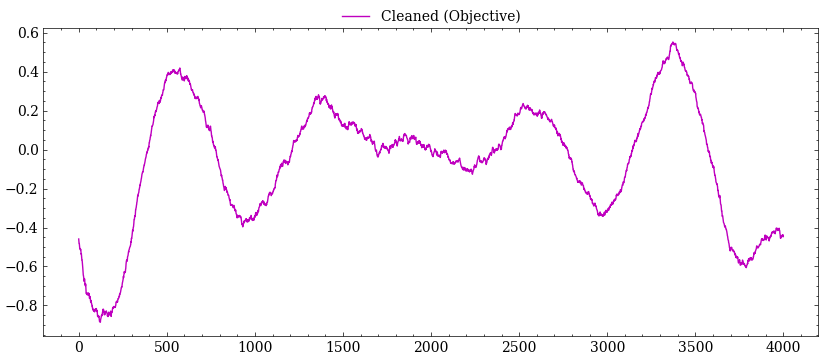

In [20]:
matdat = sio.loadmat('data/denoising_codeChallenge.mat')

cleanedSignal = matdat['cleanedSignal'][0]
origSignal = matdat['origSignal'][0]

ntime = len(origSignal)

# initialize filtered signal
origSignalf = copy.deepcopy(origSignal)

plt.figure()
plt.plot(origSignalf,'b',label='Original')
plt.plot(cleanedSignal ,'m',label='Cleaned (Objective)')

plt.xlabel('Time points')
plt.ylabel('Signal')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.1), fancybox=True, shadow=True, ncol=2)
plt.show()

plt.figure()
plt.plot(cleanedSignal ,'m',label='Cleaned (Objective)')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.1), fancybox=True, shadow=True, ncol=2)
plt.show()


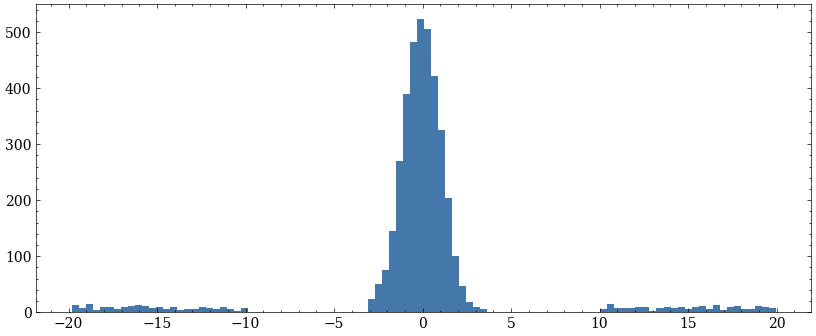

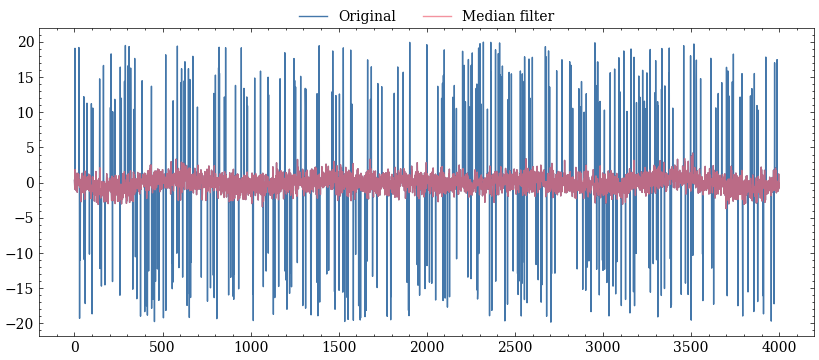

In [21]:
# APPLY MEDIAN FILTER TO REMOVE SPIKES

# use hist to pick threshold
plt.figure()
plt.hist(origSignalf,100)
plt.show()

# visual-picked threshold
thresholdSup = 5
thresholdInf = -5

# find data values above the threshold
suprathresh = np.where( origSignalf>thresholdSup )[0]
infrathresh = np.where( origSignalf<thresholdInf )[0]

# loop through suprathreshold points and set to median of k
k = 20 # actual window is k*2+1
for ti in range(len(suprathresh)):
    # lower and upper bounds
    lowbnd = np.max((0,suprathresh[ti]-k)) # to prevent picking values with index lower than 0
    uppbnd = np.min((suprathresh[ti]+k,ntime+1)) # to prevent picking values with index higher than max
    
    # compute median of surrounding points
    origSignalf[suprathresh[ti]] = np.median(origSignal[lowbnd:uppbnd])
    
for ti in range(len(infrathresh)):
    # lower and upper bounds
    lowbnd = np.max((0,infrathresh[ti]-k)) # to prevent picking values with index lower than 0
    uppbnd = np.min((infrathresh[ti]+k,ntime+1)) # to prevent picking values with index higher than max
    
    # compute median of surrounding points
    origSignalf[infrathresh[ti]] = np.median(origSignal[lowbnd:uppbnd])

# plot
plt.figure()
plt.plot(origSignal,label='Original') 
plt.plot(origSignalf,label='Median filter',alpha=0.7)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.1), fancybox=True, shadow=True, ncol=2)
plt.show()


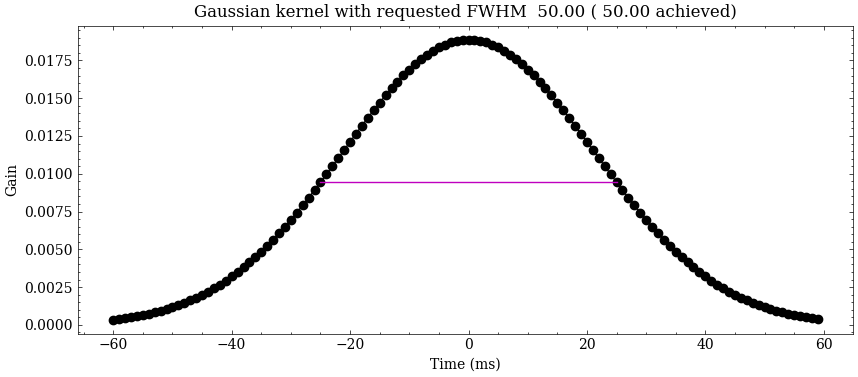

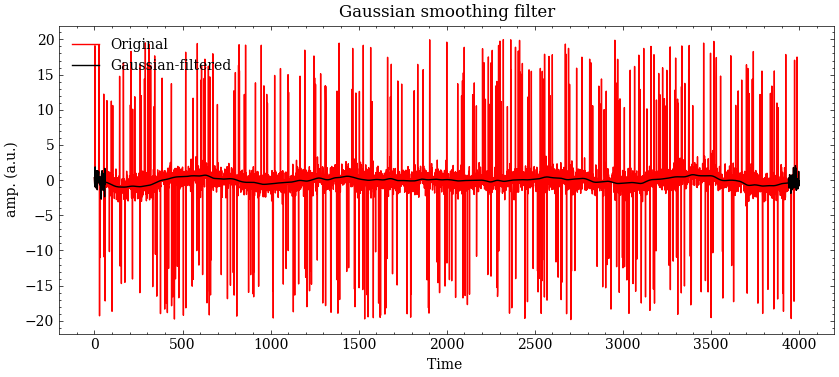

In [22]:
#  APPLY GAUSSIAN SMOOTH

## create Gaussian kernel
fwhm = 50 

k = 60

gaussx = np.arange(-k,k)

# create Gaussian window
gauswin = np.exp( -(4*np.log(2)*gaussx**2) / fwhm**2 )

# compute empirical FWHM
pstPeakHalf = k + np.argmin( (gauswin[k:]-.5)**2 )
prePeakHalf = np.argmin( (gauswin-.5)**2 )

empFWHM = gaussx[pstPeakHalf] - gaussx[prePeakHalf]

# then normalize Gaussian to unit energy
gauswin = gauswin / np.sum(gauswin) # this ensures that the scale is maintaned in the original data

# show the Gaussian
plt.figure()
plt.plot(gaussx,gauswin,'ko-')
plt.plot([gaussx[prePeakHalf],gaussx[pstPeakHalf]],[gauswin[prePeakHalf],gauswin[pstPeakHalf]],'m')

plt.title(f'Gaussian kernel with requested FWHM {fwhm : .2f} ({empFWHM : .2f} achieved)')
plt.xlabel('Time (ms)')
plt.ylabel('Gain')

plt.show()


# initialize filtered signal vector
origSignalf2 = copy.deepcopy(origSignalf)

# # implement the running mean filter
for i in range(k+1,ntime-k):
    # each point is the weighted average of k surrounding points
    origSignalf2[i] = np.sum( origSignalf[i-k:i+k]*gauswin )

# plot
plt.figure()
plt.plot(origSignal,'r',label='Original')
plt.plot(origSignalf2,'k',label='Gaussian-filtered')

plt.xlabel('Time ')
plt.ylabel('amp. (a.u.)')
plt.legend()
plt.title('Gaussian smoothing filter')

plt.show()
